## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage
import warnings

from keras.callbacks import ModelCheckpoint
from neural_networks.fcrn import FCRN_A
from utils.data.data_generator import DataGenerator
from utils.input_output.io import load_images_and_density_maps
from utils.input_output.io import read_json, write_json
from utils.visualization.vis import plot_loss, plot_some_predictions

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

## 2. Load the dataset

In [4]:
params = {
    'dim': config.DIM,
    'batch_size': config.BATCH_SIZE,
    'shuffle': config.SHUFFLE
}

In [5]:
train_generator = DataGenerator(config.DATASET_PATH, 'train', **params)
val_generator = DataGenerator(config.DATASET_PATH, 'test', **params)

## 3. Instantiate a FCRN_A

In [6]:
model = FCRN_A()

## 4. Train the model

In [7]:
!rm -rf $config.CHECKPOINTS_PATH
!rm -rf $config.LOGS_PATH
os.makedirs(config.CHECKPOINTS_PATH)
os.makedirs(config.LOGS_PATH)

In [8]:
%%time
CHECKPOINT_FILENAME = config.CHECKPOINTS_PATH + '/best_model.hdf5'

model_checkpoint = ModelCheckpoint(CHECKPOINT_FILENAME,
                                   monitor='val_loss',
                                   verbose=0,
                                   save_best_only=True)

model_history = model.fit_generator(generator=train_generator,
                                    validation_data=val_generator,
                                    epochs=config.EPOCHS,
                                    callbacks=[model_checkpoint])

Epoch 1/25
3/3 [==============================] - 12s 4s/step - loss: 1.4068 - val_loss: 0.2024
Epoch 2/25
3/3 [==============================] - 4s 1s/step - loss: 0.3340 - val_loss: 0.1809
Epoch 3/25
3/3 [==============================] - 4s 1s/step - loss: 0.2085 - val_loss: 0.2120
Epoch 4/25
3/3 [==============================] - 4s 1s/step - loss: 0.2007 - val_loss: 0.1766
Epoch 5/25
3/3 [==============================] - 4s 1s/step - loss: 0.1786 - val_loss: 0.1604
Epoch 6/25
3/3 [==============================] - 4s 1s/step - loss: 0.1627 - val_loss: 0.1668
Epoch 7/25
3/3 [==============================] - 4s 1s/step - loss: 0.1601 - val_loss: 0.1208
Epoch 8/25
3/3 [==============================] - 4s 1s/step - loss: 0.1427 - val_loss: 0.1422
Epoch 9/25
3/3 [==============================] - 4s 1s/step - loss: 0.1381 - val_loss: 0.1076
Epoch 10/25
3/3 [==============================] - 4s 1s/step - loss: 0.1202 - val_loss: 0.1180
Epoch 11/25
3/3 [==============================]

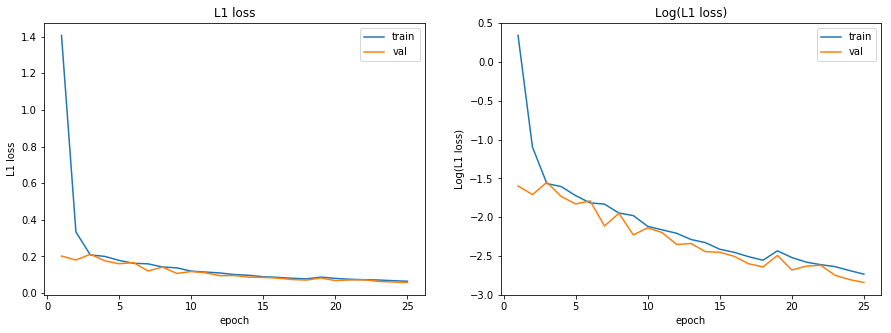

In [9]:
write_json(model.history.history, config.LOGS_FILENAME)
logs = read_json(config.LOGS_FILENAME)

plot_loss(logs['loss'], logs['val_loss'], 'L1 loss')

## 5. Look at some predictions (val set)

In [10]:
NUM_IMAGES = 3
val_images, val_density_maps = load_images_and_density_maps(config.VAL_PATH, NUM_IMAGES)

In [11]:
val_preds = model.predict(np.array(val_images)) / config.DENSITY_MAP_MULTIPLICATION_FACTOR

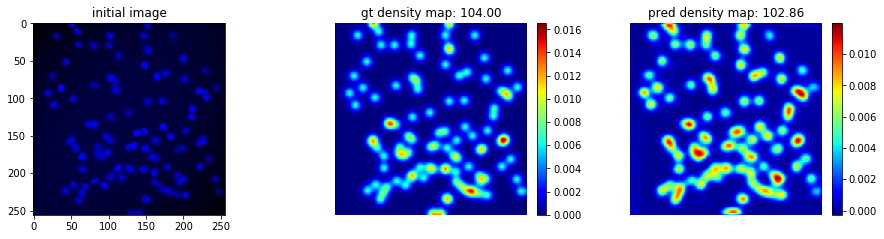

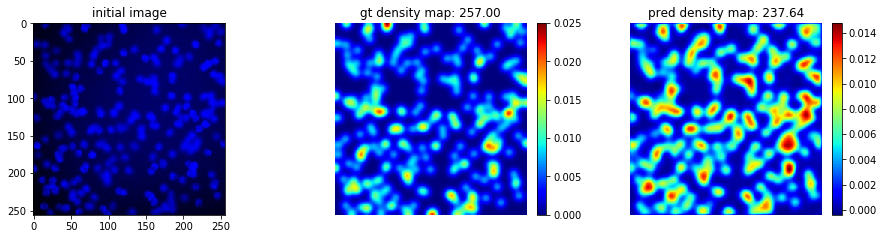

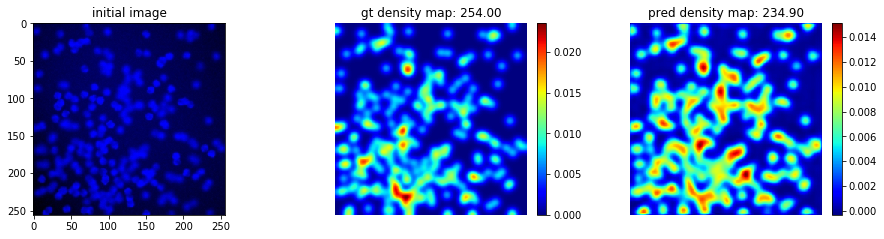

In [12]:
plot_some_predictions(val_images, val_density_maps, val_preds)

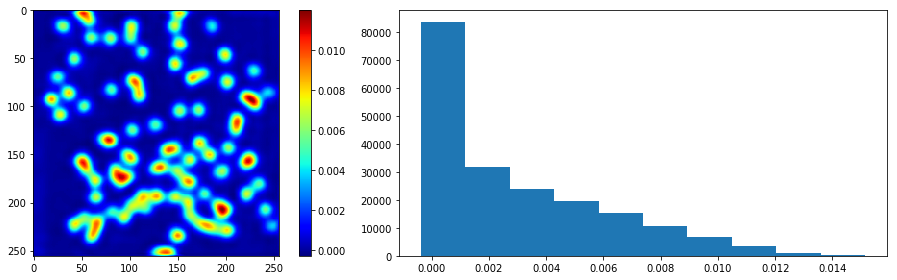

In [13]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.imshow(val_preds.squeeze()[0], cmap='jet')
plt.colorbar(fraction=0.045, pad=0.04)
plt.subplot(1, 2, 2)
plt.hist(val_preds.flatten())
plt.tight_layout()
plt.show()